---
layout: post
title: An intuitive introduction to pansharpening
categories: [geospatial]
excerpt: Pansharpening is a common operation used in the geospatial world that uses higher resolution panchromatic images to add sharpness to lower resolution multispectral images. In this post we take a look at the fundamental ideas behind pansharpening in an intuitive context. 
---

Many earth observation satellites are equipped with a higher resolution panchromatic sensor, and a lower resolution multispectral sensor. One example of this is the Pleiades satellite constellation by Airbus, for which the panchromatic sensor has a 70 cm ground sampling distance (GSD), and the multispectral sensor has a 2.8 m GSD, i.e. four times lower than the panchromatic band. 

The panchromatic band is sensitive to a wide spectrum of light, usually overlapping with several of the other spectral bands, while the multispectral bands focus on narrower parts of the spectrum. 

The image below shows the spectral resolution of the panchromatic as well the the blue, green, red and near infra-red (NIR) bands of the Pleiades sensor (taken from [here](https://www.mdpi.com/2072-4292/13/8/1550)): 


<figure>
    <img src="Spectral-response-of-the-Pleiades-multispectral-MS-and-panchromatic-PAN-sensors.png"
         alt="Pleiades Spectral Bands">
    <figcaption>Pleiades spectral bands.</figcaption>
</figure>
One of the reasons for having different resolutions for different spectral bands is that a sensor needs to receive a certain amount of light before it can form a reliable image. If you increase the spatial resolution or decrease the spectral resolution, you reduce the amount of light reaching each pixel, meaning satellite designers often have to choose between high spectral resolution or high spatial resolution. For a more in-depth explanation see this answer on [GIS StackExchange](https://gis.stackexchange.com/a/113899/224865).

What this results in is that you often have one image with high spatial information, but low spectral information, and one with low spatial information but high spectral information. 


But what if you want both?

This is where [pansharpening](https://en.wikipedia.org/wiki/Pansharpening) comes in. 

By combining the spatial information from the panchromatic image and the spectral information from the multispectral image, we can create an image with the best of both worlds. 

## An intuitive example

Remote sensing images are sometimes a bit unintuitive to deal with, so I will use a "normal" image as an example, in this case a logo I created with [Ideogram](https://ideogram.ai/):


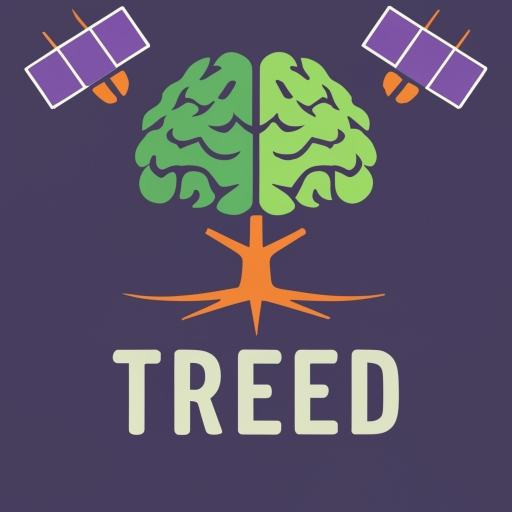

In [1]:
import PIL.Image as Image
import numpy as np
original_image = Image.open("/home/ferdi/Workspace/pansharpen/treed_brain_512.jpeg")
original_width, original_height = original_image.size
original_array = np.array(original_image)
original_image

To simulate the situation in satellite images we will create a "panchromatic" image by making a grayscale image:

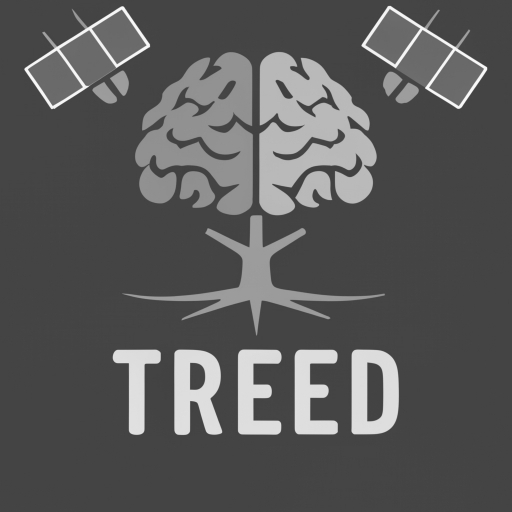

In [2]:
toy_panchromatic_image = original_image.convert("L")
toy_panchromatic_array = np.array(toy_panchromatic_image)
toy_panchromatic_image

and to simulate a lower resolution multispectral image we will downsample the image to get a lower resolution version of the colour image.  
In this case our original image had a resolution of 512 x 512 pixels, and we downsample each side by a factor of four to get a 128 x 128 pixel image, meaning for every pixel in the multispectral image we will have sixteen (4 x 4) pixels in the panchromatic image. 

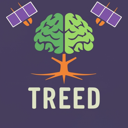

In [3]:
toy_multispectral_image = original_image.resize((original_width//4, original_width//4))
toy_multispectral_array = np.array(toy_multispectral_image)
toy_multispectral_image

To see the difference we can naively upsample the multispectral image and show the images side-by-side: 

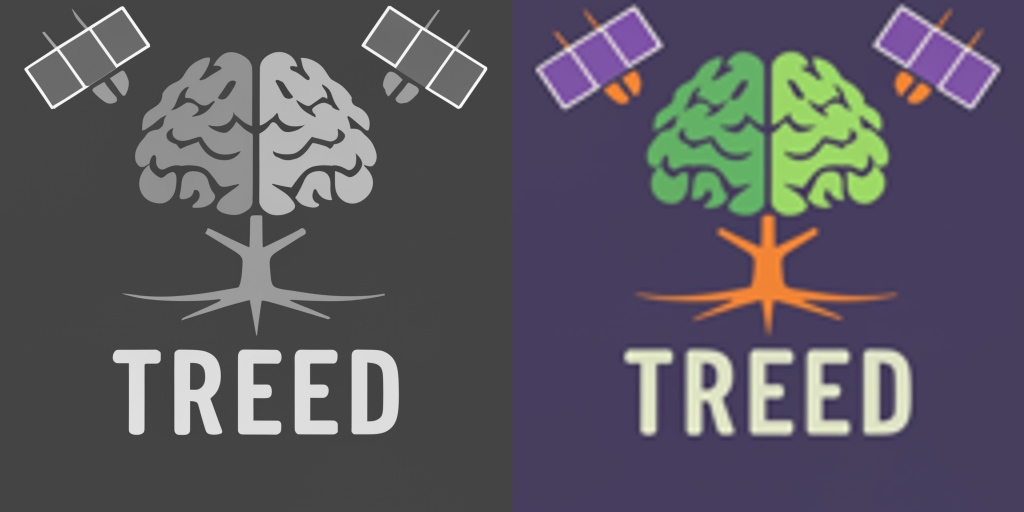

In [4]:
toy_upscaled_multispectral_image = toy_multispectral_image.resize((original_width, original_height))
toy_upscaled_multispectral_array = np.array(toy_upscaled_multispectral_image)

side_by_side = np.concatenate((toy_panchromatic_array[:,:,None].repeat(3, axis=2), toy_upscaled_multispectral_array), axis=1)
Image.fromarray(side_by_side)

As you can see we now have a high resolution "panchromatic" image and a low resolution "multispectral" image. 

So how can we add back sharpness to the image on the right? 

## Brovey pansharpening

One of the simplest (and most widely used) methods for pansharpening is called the Brovey transformation. For reference, it is the default pansharpening operation in [GDAL](https://gdal.org/index.html).

To do a Brovey transform you need to upsample the multispectral image so your images have the same resoltuion. 

We did this above, but to confirm let us check the resolutions of our images: 

In [5]:
print(f"Panchromatic shape: {toy_panchromatic_array.shape}")
print(f"Multispectral shape: {toy_upscaled_multispectral_array.shape}")

Panchromatic shape: (512, 512)
Multispectral shape: (512, 512, 3)


Next, for every pixel we create a "pseudo-pan" value by combining the values of the spectral values at each pixel of the (upsampled) multispectral image. 

So: 

\begin{equation}
\text{psuedo-pan} = R + G + B
\end{equation}

However the above assumes that the spectral bands contributed equally to the panchromatic image. 
As you can see in the illustration of the Pleiades spectral resolution, the green and red bands share a larger overlap with the pancharomatic band than the blue or NIR bands, and should therefore contribute more. In fact, the four spectral bands of the multispectral sensor do not cover the entire spectral range covered by the multispectral sensor.

Therefore we need a set of weights that tells us how each band contributes to the panchromatic image. In case of satellite sensors, these can be found via calibration and are usually available from the manufacturer. 

In the case of our toy example, we know the weights used to create our "panchromatic" image. The weights are `0.299`, `0.587` and `0.114` for red green and blue respectively, and a description of why these weights are used can be found [here](https://e2eml.school/convert_rgb_to_grayscale).

Our equation is now:
\begin{equation}
\text{weighted psuedo-pan} = 0.299 R + 0.587 G + 0.114 B
\end{equation}

and we are now technically doing a weighted Brovey transform. 

By doing this for every pixel we can get an approximation of what the expected panchromatic image should look like: 

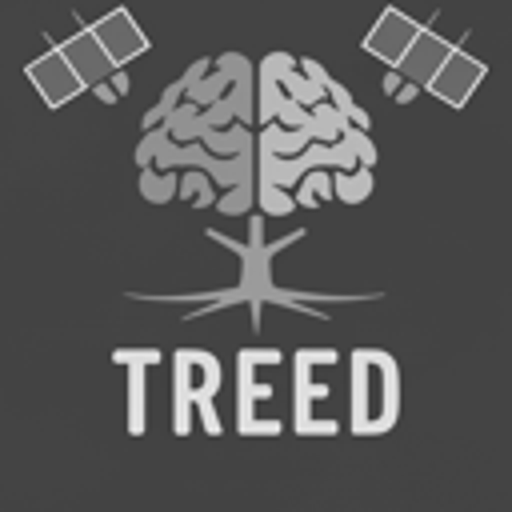

In [6]:
channel_dependant_luminance_perception = np.array([0.299, 0.587, 0.114])
psuedo_pan_array = np.true_divide((toy_upscaled_multispectral_array*channel_dependant_luminance_perception).sum(axis=2), channel_dependant_luminance_perception.sum())
psuedo_pan_image = Image.fromarray(psuedo_pan_array.astype(np.uint8))
psuedo_pan_image

By using the ratio between real panchromatic image and the psuedo-pan image we can get a map that tells us which pixels to lighten and which to darken: 

\begin{equation}
ratio = \frac{\text{panchromatic}}{ \text{weighted psuedo-pan}} 
\end{equation}

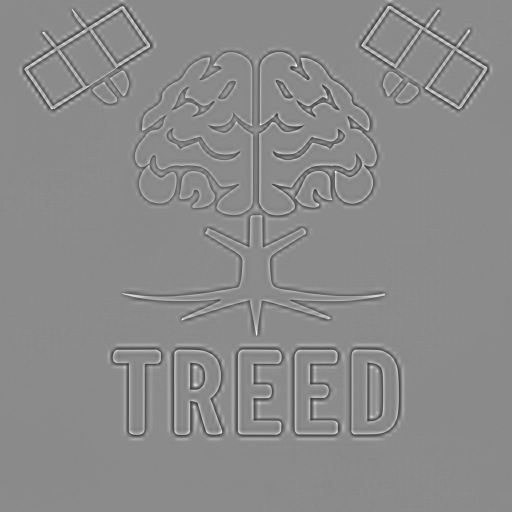

In [8]:
ratio = toy_panchromatic_array/psuedo_pan_array
Image.fromarray((ratio*255/ratio.max()).astype(np.uint8))

Applying this ratio to each of the bands of our upscaled multispectral image, we get our pansharpened image: 

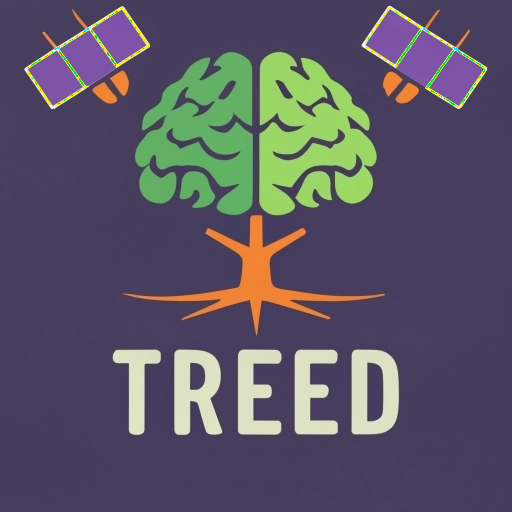

In [9]:
new_red = toy_upscaled_multispectral_array[:, :, 0] * ratio
new_green = toy_upscaled_multispectral_array[:, :, 1] * ratio
new_blue = toy_upscaled_multispectral_array[:, :, 2] * ratio
pansharpened_array = np.stack([new_red, new_green, new_blue], axis=2)
pansharpened_image = Image.fromarray(pansharpened_array.astype(np.uint8))
pansharpened_image

This looks pretty good! The image is in colour, and has crips sharp edges. 

Putting these side-by-side, with the original image on the left and the pansharpened image on the right, we can see a few small differences: 

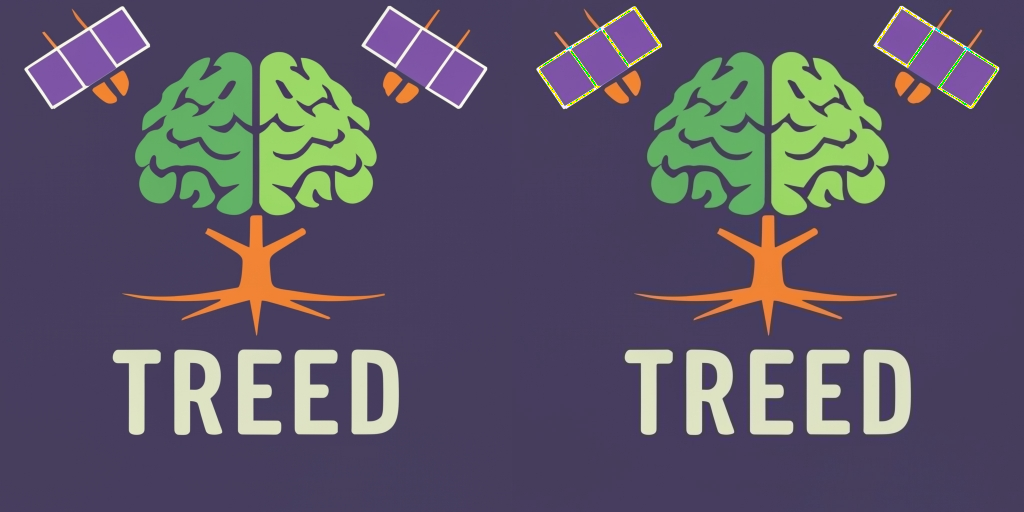

In [11]:
side_by_side = np.concatenate((original_array, pansharpened_array), axis=1)
Image.fromarray(side_by_side.astype(np.uint8))

The most prominent artefacting occurs in the white lines in the "satellites", i.e. in areas where there is a sudden change from one colour to another. 

In order to more clearly see the differences betwen the two cases, let us create a difference map: 

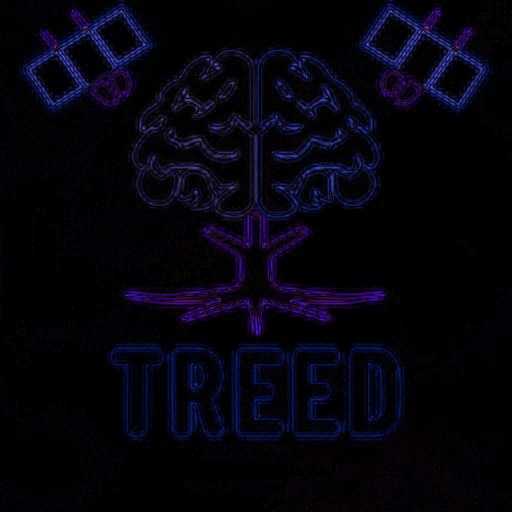

In [12]:
difference_array = np.abs((pansharpened_array - original_array))
difference_array = difference_array/difference_array.max()*255
Image.fromarray((difference_array).astype(np.uint8), mode="RGB")

As might be expected, 